In [2]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import torch

In [3]:
import kagglehub

# Download writing prompts dataset
path = kagglehub.dataset_download("ratthachat/writing-prompts")
print("Dataset downloaded to:", path)

Dataset downloaded to: C:\Users\janfa\.cache\kagglehub\datasets\ratthachat\writing-prompts\versions\1


In [4]:
import os
import pandas as pd

# Locate files
data_folder = os.path.join(path, "writingPrompts")
train_source_path = os.path.join(data_folder, "train.wp_source")
train_target_path = os.path.join(data_folder, "train.wp_target")
valid_source_path = os.path.join(data_folder, "valid.wp_source")
valid_target_path = os.path.join(data_folder, "valid.wp_target")

# Load files
def load_data(source_path, target_path):
    with open(source_path, "r", encoding="utf-8") as src_file, \
         open(target_path, "r", encoding="utf-8") as tgt_file:
        sources = src_file.readlines()
        targets = tgt_file.readlines()
    return pd.DataFrame({"source": sources, "target": targets})

train_df = load_data(train_source_path, train_target_path)
valid_df = load_data(valid_source_path, valid_target_path)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))

Train size: 272600
Valid size: 15620


In [5]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

# Load tokenizer and model
model_name = "sshleifer/tiny-gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)

c:\Users\janfa\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Prepare Huggingface Datasets
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

In [7]:
# Tokenize
def tokenize_function(batch):
    texts = [src + " " + tgt for src, tgt in zip(batch['source'], batch['target'])]
    tokens = tokenizer(texts, truncation=True, padding="max_length", max_length=512)
    return tokens

train_tokenized = train_dataset.map(tokenize_function, batched=True, remove_columns=["source", "target"])
valid_tokenized = valid_dataset.map(tokenize_function, batched=True, remove_columns=["source", "target"])


Map:   0%|          | 0/272600 [00:00<?, ? examples/s]

Map:   0%|          | 0/15620 [00:00<?, ? examples/s]

In [8]:
# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 2)
    (wpe): Embedding(1024, 2)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2, out_features=50257, bias=False)
)

In [12]:
# Training args
training_args = TrainingArguments(
    output_dir="./outputs/model",
    evaluation_strategy="steps",
    eval_steps=10000,
    logging_steps=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_steps=200,
    save_total_limit=2,
    fp16=True,
    report_to="none",
    logging_dir="./outputs/logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    data_collator=data_collator,
)

# Fine-tune
trainer.train()

c:\Users\janfa\AppData\Local\Programs\Python\Python39\lib\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
c:\Users\janfa\AppData\Local\Programs\Python\Python39\lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/204450 [00:00<?, ?it/s]

{'loss': 10.8221, 'grad_norm': 0.4662328362464905, 'learning_rate': 4.9987772071411104e-05, 'epoch': 0.0}
{'loss': 10.8144, 'grad_norm': 0.43245741724967957, 'learning_rate': 4.9975544142822206e-05, 'epoch': 0.0}
{'loss': 10.8031, 'grad_norm': 0.28175851702690125, 'learning_rate': 4.9963316214233315e-05, 'epoch': 0.0}
{'loss': 10.7933, 'grad_norm': 0.23385071754455566, 'learning_rate': 4.995108828564442e-05, 'epoch': 0.0}
{'loss': 10.7848, 'grad_norm': 0.20179438591003418, 'learning_rate': 4.993886035705552e-05, 'epoch': 0.0}
{'loss': 10.7769, 'grad_norm': 0.20054496824741364, 'learning_rate': 4.992663242846662e-05, 'epoch': 0.0}
{'loss': 10.769, 'grad_norm': 0.2122679054737091, 'learning_rate': 4.991440449987772e-05, 'epoch': 0.01}
{'loss': 10.7609, 'grad_norm': 0.18059340119361877, 'learning_rate': 4.990217657128883e-05, 'epoch': 0.01}
{'loss': 10.7537, 'grad_norm': 0.19257235527038574, 'learning_rate': 4.988994864269993e-05, 'epoch': 0.01}
{'loss': 10.7457, 'grad_norm': 0.2357026487

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 8.466972351074219, 'eval_runtime': 53.9702, 'eval_samples_per_second': 289.419, 'eval_steps_per_second': 72.355, 'epoch': 0.15}
{'loss': 8.4647, 'grad_norm': 0.9592816233634949, 'learning_rate': 4.754292002934703e-05, 'epoch': 0.15}
{'loss': 8.4728, 'grad_norm': 0.9780864119529724, 'learning_rate': 4.7530692100758134e-05, 'epoch': 0.15}
{'loss': 8.4332, 'grad_norm': 1.0085285902023315, 'learning_rate': 4.7518464172169236e-05, 'epoch': 0.15}
{'loss': 8.4181, 'grad_norm': 0.9354308843612671, 'learning_rate': 4.750623624358034e-05, 'epoch': 0.15}
{'loss': 8.4015, 'grad_norm': 0.951987624168396, 'learning_rate': 4.7494008314991446e-05, 'epoch': 0.15}
{'loss': 8.4204, 'grad_norm': 1.0015957355499268, 'learning_rate': 4.748178038640255e-05, 'epoch': 0.15}
{'loss': 8.3914, 'grad_norm': 0.901093602180481, 'learning_rate': 4.746955245781365e-05, 'epoch': 0.15}
{'loss': 8.38, 'grad_norm': 1.0015788078308105, 'learning_rate': 4.745732452922475e-05, 'epoch': 0.15}
{'loss': 8.344, 'gr

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.690668106079102, 'eval_runtime': 53.6361, 'eval_samples_per_second': 291.222, 'eval_steps_per_second': 72.805, 'epoch': 0.29}
{'loss': 6.7452, 'grad_norm': 0.3755062222480774, 'learning_rate': 4.509806798728295e-05, 'epoch': 0.29}
{'loss': 6.711, 'grad_norm': 0.5132809281349182, 'learning_rate': 4.508584005869406e-05, 'epoch': 0.29}
{'loss': 6.7116, 'grad_norm': 0.37817227840423584, 'learning_rate': 4.507361213010516e-05, 'epoch': 0.3}
{'loss': 6.6615, 'grad_norm': 0.4037098288536072, 'learning_rate': 4.5061384201516265e-05, 'epoch': 0.3}
{'loss': 6.7044, 'grad_norm': 0.43586084246635437, 'learning_rate': 4.504915627292737e-05, 'epoch': 0.3}
{'loss': 6.6852, 'grad_norm': 0.4100264608860016, 'learning_rate': 4.503692834433847e-05, 'epoch': 0.3}
{'loss': 6.719, 'grad_norm': 0.3335222601890564, 'learning_rate': 4.502470041574958e-05, 'epoch': 0.3}
{'loss': 6.6527, 'grad_norm': 0.3842344582080841, 'learning_rate': 4.501247248716068e-05, 'epoch': 0.3}
{'loss': 6.6996, 'grad_

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.600673198699951, 'eval_runtime': 52.171, 'eval_samples_per_second': 299.4, 'eval_steps_per_second': 74.85, 'epoch': 0.44}
{'loss': 6.6223, 'grad_norm': 0.1662595272064209, 'learning_rate': 4.265346050379066e-05, 'epoch': 0.44}
{'loss': 6.639, 'grad_norm': 0.1501735895872116, 'learning_rate': 4.264123257520176e-05, 'epoch': 0.44}
{'loss': 6.6057, 'grad_norm': 0.23078100383281708, 'learning_rate': 4.262900464661286e-05, 'epoch': 0.44}
{'loss': 6.6636, 'grad_norm': 0.2523295283317566, 'learning_rate': 4.261677671802397e-05, 'epoch': 0.44}
{'loss': 6.5888, 'grad_norm': 0.1501857042312622, 'learning_rate': 4.260454878943507e-05, 'epoch': 0.44}
{'loss': 6.5997, 'grad_norm': 0.15064692497253418, 'learning_rate': 4.2592320860846174e-05, 'epoch': 0.44}
{'loss': 6.6272, 'grad_norm': 0.20504072308540344, 'learning_rate': 4.2580092932257276e-05, 'epoch': 0.45}
{'loss': 6.6463, 'grad_norm': 0.16545549035072327, 'learning_rate': 4.256786500366838e-05, 'epoch': 0.45}
{'loss': 6.6286, 

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596961975097656, 'eval_runtime': 51.9868, 'eval_samples_per_second': 300.461, 'eval_steps_per_second': 75.115, 'epoch': 0.59}
{'loss': 6.5507, 'grad_norm': 0.20721039175987244, 'learning_rate': 4.0208608461726586e-05, 'epoch': 0.59}
{'loss': 6.6057, 'grad_norm': 0.19785776734352112, 'learning_rate': 4.019638053313769e-05, 'epoch': 0.59}
{'loss': 6.6059, 'grad_norm': 0.15543873608112335, 'learning_rate': 4.018415260454879e-05, 'epoch': 0.59}
{'loss': 6.5938, 'grad_norm': 0.1501796692609787, 'learning_rate': 4.017192467595989e-05, 'epoch': 0.59}
{'loss': 6.5887, 'grad_norm': 0.16635699570178986, 'learning_rate': 4.015969674737099e-05, 'epoch': 0.59}
{'loss': 6.6128, 'grad_norm': 0.2447192519903183, 'learning_rate': 4.01474688187821e-05, 'epoch': 0.59}
{'loss': 6.6239, 'grad_norm': 0.16142256557941437, 'learning_rate': 4.0135240890193204e-05, 'epoch': 0.59}
{'loss': 6.6268, 'grad_norm': 0.15929991006851196, 'learning_rate': 4.0123012961604306e-05, 'epoch': 0.59}
{'loss': 6

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.595640659332275, 'eval_runtime': 52.1078, 'eval_samples_per_second': 299.763, 'eval_steps_per_second': 74.941, 'epoch': 0.73}
{'loss': 6.6346, 'grad_norm': 0.21900686621665955, 'learning_rate': 3.776375641966251e-05, 'epoch': 0.73}
{'loss': 6.5858, 'grad_norm': 0.19681178033351898, 'learning_rate': 3.7751528491073615e-05, 'epoch': 0.74}
{'loss': 6.6335, 'grad_norm': 0.16690412163734436, 'learning_rate': 3.773930056248472e-05, 'epoch': 0.74}
{'loss': 6.6375, 'grad_norm': 0.17998774349689484, 'learning_rate': 3.772707263389582e-05, 'epoch': 0.74}
{'loss': 6.6075, 'grad_norm': 0.31035396456718445, 'learning_rate': 3.771484470530692e-05, 'epoch': 0.74}
{'loss': 6.5492, 'grad_norm': 0.16878215968608856, 'learning_rate': 3.770261677671802e-05, 'epoch': 0.74}
{'loss': 6.5957, 'grad_norm': 0.21425385773181915, 'learning_rate': 3.7690388848129124e-05, 'epoch': 0.74}
{'loss': 6.6194, 'grad_norm': 0.15612143278121948, 'learning_rate': 3.767816091954023e-05, 'epoch': 0.74}
{'loss':

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.59613037109375, 'eval_runtime': 51.9978, 'eval_samples_per_second': 300.398, 'eval_steps_per_second': 75.099, 'epoch': 0.88}
{'loss': 6.5626, 'grad_norm': 0.15751439332962036, 'learning_rate': 3.531914893617021e-05, 'epoch': 0.88}
{'loss': 6.6214, 'grad_norm': 0.16608388721942902, 'learning_rate': 3.5306921007581314e-05, 'epoch': 0.88}
{'loss': 6.5924, 'grad_norm': 0.17426697909832, 'learning_rate': 3.5294693078992416e-05, 'epoch': 0.88}
{'loss': 6.6401, 'grad_norm': 0.18932528793811798, 'learning_rate': 3.528246515040352e-05, 'epoch': 0.88}
{'loss': 6.6121, 'grad_norm': 0.1453637331724167, 'learning_rate': 3.5270237221814626e-05, 'epoch': 0.88}
{'loss': 6.5903, 'grad_norm': 0.17079803347587585, 'learning_rate': 3.525800929322573e-05, 'epoch': 0.88}
{'loss': 6.6128, 'grad_norm': 0.23508945107460022, 'learning_rate': 3.524578136463683e-05, 'epoch': 0.89}
{'loss': 6.5902, 'grad_norm': 0.13209396600723267, 'learning_rate': 3.523355343604793e-05, 'epoch': 0.89}
{'loss': 6.6

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.595510482788086, 'eval_runtime': 52.2118, 'eval_samples_per_second': 299.166, 'eval_steps_per_second': 74.791, 'epoch': 1.03}
{'loss': 6.5678, 'grad_norm': 0.14768995344638824, 'learning_rate': 3.287429689410614e-05, 'epoch': 1.03}
{'loss': 6.5932, 'grad_norm': 0.13583174347877502, 'learning_rate': 3.286206896551725e-05, 'epoch': 1.03}
{'loss': 6.5604, 'grad_norm': 0.19092409312725067, 'learning_rate': 3.284984103692835e-05, 'epoch': 1.03}
{'loss': 6.6207, 'grad_norm': 0.20934578776359558, 'learning_rate': 3.283761310833945e-05, 'epoch': 1.03}
{'loss': 6.669, 'grad_norm': 0.19419491291046143, 'learning_rate': 3.2825385179750554e-05, 'epoch': 1.03}
{'loss': 6.5848, 'grad_norm': 0.21486762166023254, 'learning_rate': 3.2813157251161656e-05, 'epoch': 1.03}
{'loss': 6.5764, 'grad_norm': 0.16326047480106354, 'learning_rate': 3.280092932257276e-05, 'epoch': 1.03}
{'loss': 6.5766, 'grad_norm': 0.1486707329750061, 'learning_rate': 3.278870139398386e-05, 'epoch': 1.03}
{'loss': 6

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596205234527588, 'eval_runtime': 52.5549, 'eval_samples_per_second': 297.213, 'eval_steps_per_second': 74.303, 'epoch': 1.17}
{'loss': 6.5851, 'grad_norm': 0.16449691355228424, 'learning_rate': 3.0429689410613842e-05, 'epoch': 1.17}
{'loss': 6.631, 'grad_norm': 0.19220991432666779, 'learning_rate': 3.0417461482024944e-05, 'epoch': 1.18}
{'loss': 6.6336, 'grad_norm': 0.19947728514671326, 'learning_rate': 3.0405233553436046e-05, 'epoch': 1.18}
{'loss': 6.6081, 'grad_norm': 0.12882159650325775, 'learning_rate': 3.0393005624847154e-05, 'epoch': 1.18}
{'loss': 6.6257, 'grad_norm': 0.15041299164295197, 'learning_rate': 3.0380777696258256e-05, 'epoch': 1.18}
{'loss': 6.5559, 'grad_norm': 0.209985613822937, 'learning_rate': 3.0368549767669358e-05, 'epoch': 1.18}
{'loss': 6.6073, 'grad_norm': 0.17365582287311554, 'learning_rate': 3.035632183908046e-05, 'epoch': 1.18}
{'loss': 6.5943, 'grad_norm': 0.1778884381055832, 'learning_rate': 3.0344093910491565e-05, 'epoch': 1.18}
{'loss'

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.5961151123046875, 'eval_runtime': 51.9848, 'eval_samples_per_second': 300.473, 'eval_steps_per_second': 75.118, 'epoch': 1.32}
{'loss': 6.5737, 'grad_norm': 0.17895330488681793, 'learning_rate': 2.7985081927121548e-05, 'epoch': 1.32}
{'loss': 6.5996, 'grad_norm': 0.16423022747039795, 'learning_rate': 2.797285399853265e-05, 'epoch': 1.32}
{'loss': 6.5668, 'grad_norm': 0.18016931414604187, 'learning_rate': 2.796062606994375e-05, 'epoch': 1.32}
{'loss': 6.6199, 'grad_norm': 0.18706151843070984, 'learning_rate': 2.7948398141354853e-05, 'epoch': 1.32}
{'loss': 6.6324, 'grad_norm': 0.16407574713230133, 'learning_rate': 2.7936170212765962e-05, 'epoch': 1.32}
{'loss': 6.633, 'grad_norm': 0.16308194398880005, 'learning_rate': 2.7923942284177064e-05, 'epoch': 1.33}
{'loss': 6.6033, 'grad_norm': 0.12292449921369553, 'learning_rate': 2.7911714355588166e-05, 'epoch': 1.33}
{'loss': 6.5898, 'grad_norm': 0.16930656135082245, 'learning_rate': 2.7899486426999268e-05, 'epoch': 1.33}
{'lo

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.595915794372559, 'eval_runtime': 52.2228, 'eval_samples_per_second': 299.103, 'eval_steps_per_second': 74.776, 'epoch': 1.47}
{'loss': 6.6262, 'grad_norm': 0.21183758974075317, 'learning_rate': 2.554071900220103e-05, 'epoch': 1.47}
{'loss': 6.632, 'grad_norm': 0.17438536882400513, 'learning_rate': 2.5528491073612134e-05, 'epoch': 1.47}
{'loss': 6.5767, 'grad_norm': 0.23776556551456451, 'learning_rate': 2.5516263145023232e-05, 'epoch': 1.47}
{'loss': 6.617, 'grad_norm': 0.13329489529132843, 'learning_rate': 2.5504035216434334e-05, 'epoch': 1.47}
{'loss': 6.6068, 'grad_norm': 0.14328207075595856, 'learning_rate': 2.5491807287845443e-05, 'epoch': 1.47}
{'loss': 6.6176, 'grad_norm': 0.23441767692565918, 'learning_rate': 2.5479579359256544e-05, 'epoch': 1.47}
{'loss': 6.6422, 'grad_norm': 0.1866142451763153, 'learning_rate': 2.5467351430667646e-05, 'epoch': 1.47}
{'loss': 6.6643, 'grad_norm': 0.19695931673049927, 'learning_rate': 2.5455123502078748e-05, 'epoch': 1.47}
{'loss

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.59605073928833, 'eval_runtime': 52.1708, 'eval_samples_per_second': 299.401, 'eval_steps_per_second': 74.85, 'epoch': 1.61}
{'loss': 6.5987, 'grad_norm': 0.15193194150924683, 'learning_rate': 2.3095866960136952e-05, 'epoch': 1.61}
{'loss': 6.6207, 'grad_norm': 0.22268517315387726, 'learning_rate': 2.3083639031548058e-05, 'epoch': 1.62}
{'loss': 6.6071, 'grad_norm': 0.19942492246627808, 'learning_rate': 2.307141110295916e-05, 'epoch': 1.62}
{'loss': 6.6471, 'grad_norm': 0.1450907588005066, 'learning_rate': 2.3059183174370265e-05, 'epoch': 1.62}
{'loss': 6.6194, 'grad_norm': 0.13471420109272003, 'learning_rate': 2.3046955245781367e-05, 'epoch': 1.62}
{'loss': 6.6096, 'grad_norm': 0.23730064928531647, 'learning_rate': 2.303472731719247e-05, 'epoch': 1.62}
{'loss': 6.6551, 'grad_norm': 0.18874230980873108, 'learning_rate': 2.302249938860357e-05, 'epoch': 1.62}
{'loss': 6.5873, 'grad_norm': 0.15476961433887482, 'learning_rate': 2.3010271460014672e-05, 'epoch': 1.62}
{'loss':

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.5957255363464355, 'eval_runtime': 52.6849, 'eval_samples_per_second': 296.48, 'eval_steps_per_second': 74.12, 'epoch': 1.76}
{'loss': 6.624, 'grad_norm': 0.16461969912052155, 'learning_rate': 2.0651259476644658e-05, 'epoch': 1.76}
{'loss': 6.5818, 'grad_norm': 0.18103590607643127, 'learning_rate': 2.063903154805576e-05, 'epoch': 1.76}
{'loss': 6.588, 'grad_norm': 0.1371813267469406, 'learning_rate': 2.0626803619466865e-05, 'epoch': 1.76}
{'loss': 6.6699, 'grad_norm': 0.27000656723976135, 'learning_rate': 2.0614575690877967e-05, 'epoch': 1.76}
{'loss': 6.613, 'grad_norm': 0.20757155120372772, 'learning_rate': 2.060234776228907e-05, 'epoch': 1.76}
{'loss': 6.6656, 'grad_norm': 0.25077196955680847, 'learning_rate': 2.059011983370017e-05, 'epoch': 1.77}
{'loss': 6.6218, 'grad_norm': 0.17646872997283936, 'learning_rate': 2.0577891905111273e-05, 'epoch': 1.77}
{'loss': 6.5758, 'grad_norm': 0.2214033305644989, 'learning_rate': 2.0565663976522378e-05, 'epoch': 1.77}
{'loss': 6.

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596512317657471, 'eval_runtime': 51.8637, 'eval_samples_per_second': 301.174, 'eval_steps_per_second': 75.293, 'epoch': 1.91}
{'loss': 6.6443, 'grad_norm': 0.15587401390075684, 'learning_rate': 1.8206407434580582e-05, 'epoch': 1.91}
{'loss': 6.5988, 'grad_norm': 0.16778670251369476, 'learning_rate': 1.8194179505991684e-05, 'epoch': 1.91}
{'loss': 6.5928, 'grad_norm': 0.16466718912124634, 'learning_rate': 1.818195157740279e-05, 'epoch': 1.91}
{'loss': 6.5281, 'grad_norm': 0.20278464257717133, 'learning_rate': 1.816972364881389e-05, 'epoch': 1.91}
{'loss': 6.6445, 'grad_norm': 0.17356657981872559, 'learning_rate': 1.8157495720224996e-05, 'epoch': 1.91}
{'loss': 6.5916, 'grad_norm': 0.33413270115852356, 'learning_rate': 1.81452677916361e-05, 'epoch': 1.91}
{'loss': 6.588, 'grad_norm': 0.126168891787529, 'learning_rate': 1.8133039863047204e-05, 'epoch': 1.91}
{'loss': 6.6575, 'grad_norm': 0.1337570995092392, 'learning_rate': 1.8120811934458305e-05, 'epoch': 1.91}
{'loss': 6

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596283435821533, 'eval_runtime': 52.0128, 'eval_samples_per_second': 300.311, 'eval_steps_per_second': 75.078, 'epoch': 2.05}
{'loss': 6.6158, 'grad_norm': 0.20866259932518005, 'learning_rate': 1.5761799951088284e-05, 'epoch': 2.06}
{'loss': 6.5667, 'grad_norm': 0.3030611276626587, 'learning_rate': 1.574957202249939e-05, 'epoch': 2.06}
{'loss': 6.6123, 'grad_norm': 0.3594948947429657, 'learning_rate': 1.573734409391049e-05, 'epoch': 2.06}
{'loss': 6.5982, 'grad_norm': 0.15797032415866852, 'learning_rate': 1.5725116165321597e-05, 'epoch': 2.06}
{'loss': 6.629, 'grad_norm': 0.15971998870372772, 'learning_rate': 1.57128882367327e-05, 'epoch': 2.06}
{'loss': 6.6009, 'grad_norm': 0.1732090413570404, 'learning_rate': 1.5700660308143804e-05, 'epoch': 2.06}
{'loss': 6.5994, 'grad_norm': 0.22052468359470367, 'learning_rate': 1.5688432379554906e-05, 'epoch': 2.06}
{'loss': 6.6159, 'grad_norm': 0.17887508869171143, 'learning_rate': 1.5676204450966004e-05, 'epoch': 2.06}
{'loss': 6

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596419811248779, 'eval_runtime': 52.1958, 'eval_samples_per_second': 299.258, 'eval_steps_per_second': 74.814, 'epoch': 2.2}
{'loss': 6.6086, 'grad_norm': 0.1912073940038681, 'learning_rate': 1.331719246759599e-05, 'epoch': 2.2}
{'loss': 6.5433, 'grad_norm': 0.12019768357276917, 'learning_rate': 1.3304964539007092e-05, 'epoch': 2.2}
{'loss': 6.5617, 'grad_norm': 0.12717974185943604, 'learning_rate': 1.3292736610418197e-05, 'epoch': 2.2}
{'loss': 6.6028, 'grad_norm': 0.1530914604663849, 'learning_rate': 1.32805086818293e-05, 'epoch': 2.2}
{'loss': 6.6426, 'grad_norm': 0.14035604894161224, 'learning_rate': 1.3268280753240403e-05, 'epoch': 2.2}
{'loss': 6.6287, 'grad_norm': 0.24438245594501495, 'learning_rate': 1.3256052824651505e-05, 'epoch': 2.21}
{'loss': 6.5931, 'grad_norm': 0.15673203766345978, 'learning_rate': 1.3243824896062607e-05, 'epoch': 2.21}
{'loss': 6.6, 'grad_norm': 0.18460603058338165, 'learning_rate': 1.3231596967473712e-05, 'epoch': 2.21}
{'loss': 6.6155,

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.5961408615112305, 'eval_runtime': 51.9728, 'eval_samples_per_second': 300.542, 'eval_steps_per_second': 75.136, 'epoch': 2.35}
{'loss': 6.6039, 'grad_norm': 0.7863185405731201, 'learning_rate': 1.0872340425531916e-05, 'epoch': 2.35}
{'loss': 6.585, 'grad_norm': 0.16406451165676117, 'learning_rate': 1.086011249694302e-05, 'epoch': 2.35}
{'loss': 6.6221, 'grad_norm': 0.14373384416103363, 'learning_rate': 1.0847884568354121e-05, 'epoch': 2.35}
{'loss': 6.6415, 'grad_norm': 0.11945680528879166, 'learning_rate': 1.0835656639765223e-05, 'epoch': 2.35}
{'loss': 6.6586, 'grad_norm': 0.1705426126718521, 'learning_rate': 1.0823428711176327e-05, 'epoch': 2.35}
{'loss': 6.5885, 'grad_norm': 0.3366472125053406, 'learning_rate': 1.081120078258743e-05, 'epoch': 2.35}
{'loss': 6.5813, 'grad_norm': 0.19169658422470093, 'learning_rate': 1.0798972853998534e-05, 'epoch': 2.35}
{'loss': 6.6467, 'grad_norm': 0.2739146649837494, 'learning_rate': 1.0786744925409636e-05, 'epoch': 2.35}
{'loss':

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596540927886963, 'eval_runtime': 52.1588, 'eval_samples_per_second': 299.47, 'eval_steps_per_second': 74.868, 'epoch': 2.49}
{'loss': 6.5886, 'grad_norm': 0.19008319079875946, 'learning_rate': 8.42773294203962e-06, 'epoch': 2.5}
{'loss': 6.602, 'grad_norm': 0.23417341709136963, 'learning_rate': 8.415505013450722e-06, 'epoch': 2.5}
{'loss': 6.6423, 'grad_norm': 0.14293453097343445, 'learning_rate': 8.403277084861824e-06, 'epoch': 2.5}
{'loss': 6.6299, 'grad_norm': 0.35154688358306885, 'learning_rate': 8.391049156272927e-06, 'epoch': 2.5}
{'loss': 6.6602, 'grad_norm': 0.2641940414905548, 'learning_rate': 8.378821227684031e-06, 'epoch': 2.5}
{'loss': 6.6401, 'grad_norm': 0.17467358708381653, 'learning_rate': 8.366593299095135e-06, 'epoch': 2.5}
{'loss': 6.573, 'grad_norm': 0.31264883279800415, 'learning_rate': 8.354365370506236e-06, 'epoch': 2.5}
{'loss': 6.6548, 'grad_norm': 0.20489788055419922, 'learning_rate': 8.34213744191734e-06, 'epoch': 2.5}
{'loss': 6.6096, 'grad_n

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.59654426574707, 'eval_runtime': 52.3598, 'eval_samples_per_second': 298.32, 'eval_steps_per_second': 74.58, 'epoch': 2.64}
{'loss': 6.6527, 'grad_norm': 0.17041908204555511, 'learning_rate': 5.983125458547322e-06, 'epoch': 2.64}
{'loss': 6.616, 'grad_norm': 0.15686996281147003, 'learning_rate': 5.970897529958425e-06, 'epoch': 2.64}
{'loss': 6.6232, 'grad_norm': 0.15864652395248413, 'learning_rate': 5.958669601369529e-06, 'epoch': 2.64}
{'loss': 6.5715, 'grad_norm': 0.15224489569664001, 'learning_rate': 5.946441672780631e-06, 'epoch': 2.64}
{'loss': 6.5954, 'grad_norm': 0.1726657897233963, 'learning_rate': 5.934213744191734e-06, 'epoch': 2.64}
{'loss': 6.6045, 'grad_norm': 0.24142314493656158, 'learning_rate': 5.921985815602838e-06, 'epoch': 2.65}
{'loss': 6.6096, 'grad_norm': 0.1631961315870285, 'learning_rate': 5.90975788701394e-06, 'epoch': 2.65}
{'loss': 6.6203, 'grad_norm': 0.402738481760025, 'learning_rate': 5.897529958425043e-06, 'epoch': 2.65}
{'loss': 6.6009, 'g

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596782207489014, 'eval_runtime': 52.2738, 'eval_samples_per_second': 298.811, 'eval_steps_per_second': 74.703, 'epoch': 2.79}
{'loss': 6.5977, 'grad_norm': 0.18718111515045166, 'learning_rate': 3.53802885791147e-06, 'epoch': 2.79}
{'loss': 6.6201, 'grad_norm': 0.16858743131160736, 'learning_rate': 3.525800929322573e-06, 'epoch': 2.79}
{'loss': 6.5846, 'grad_norm': 0.13678327202796936, 'learning_rate': 3.5135730007336762e-06, 'epoch': 2.79}
{'loss': 6.5725, 'grad_norm': 0.1275421380996704, 'learning_rate': 3.5013450721447785e-06, 'epoch': 2.79}
{'loss': 6.5983, 'grad_norm': 0.17024420201778412, 'learning_rate': 3.4891171435558817e-06, 'epoch': 2.79}
{'loss': 6.6211, 'grad_norm': 0.16778254508972168, 'learning_rate': 3.476889214966985e-06, 'epoch': 2.79}
{'loss': 6.5876, 'grad_norm': 0.1617569774389267, 'learning_rate': 3.4646612863780876e-06, 'epoch': 2.79}
{'loss': 6.6101, 'grad_norm': 0.1421203762292862, 'learning_rate': 3.4524333577891907e-06, 'epoch': 2.79}
{'loss': 

  0%|          | 0/3905 [00:00<?, ?it/s]

{'eval_loss': 6.596745491027832, 'eval_runtime': 52.1988, 'eval_samples_per_second': 299.241, 'eval_steps_per_second': 74.81, 'epoch': 2.93}
{'loss': 6.6261, 'grad_norm': 0.1781528741121292, 'learning_rate': 1.0934213744191735e-06, 'epoch': 2.94}
{'loss': 6.5922, 'grad_norm': 0.1646558940410614, 'learning_rate': 1.0811934458302765e-06, 'epoch': 2.94}
{'loss': 6.5736, 'grad_norm': 0.34306225180625916, 'learning_rate': 1.0689655172413794e-06, 'epoch': 2.94}
{'loss': 6.6434, 'grad_norm': 0.19885815680027008, 'learning_rate': 1.0567375886524824e-06, 'epoch': 2.94}
{'loss': 6.6437, 'grad_norm': 0.15750592947006226, 'learning_rate': 1.0445096600635853e-06, 'epoch': 2.94}
{'loss': 6.5822, 'grad_norm': 0.16312628984451294, 'learning_rate': 1.0322817314746882e-06, 'epoch': 2.94}
{'loss': 6.6324, 'grad_norm': 0.15246909856796265, 'learning_rate': 1.0200538028857912e-06, 'epoch': 2.94}
{'loss': 6.615, 'grad_norm': 0.27401790022850037, 'learning_rate': 1.0078258742968941e-06, 'epoch': 2.94}
{'loss

TrainOutput(global_step=204450, training_loss=6.801539001688743, metrics={'train_runtime': 7076.0626, 'train_samples_per_second': 115.573, 'train_steps_per_second': 28.893, 'train_loss': 6.801539001688743, 'epoch': 3.0})

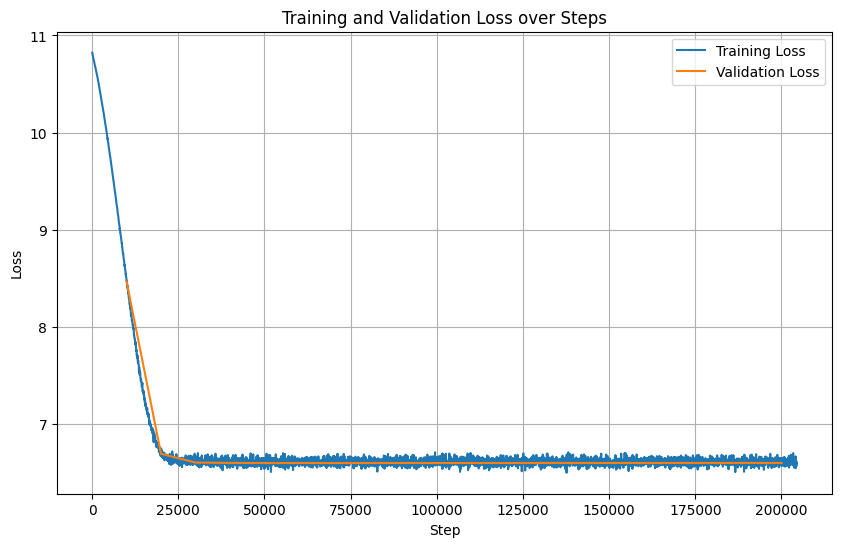

In [13]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

# Filter
train_loss_df = log_df[log_df['loss'].notnull()]
eval_loss_df = log_df[log_df['eval_loss'].notnull()]

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training Loss')
plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save model
trainer.save_model("./outputs/model")
tokenizer.save_pretrained("./outputs/model")

('./outputs/model\\tokenizer_config.json',
 './outputs/model\\special_tokens_map.json',
 './outputs/model\\vocab.json',
 './outputs/model\\merges.txt',
 './outputs/model\\added_tokens.json')

In [15]:
import torch
import math

model = GPT2LMHeadModel.from_pretrained("./outputs/model")
tokenizer = GPT2Tokenizer.from_pretrained("./outputs/model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

total_loss = 0
total_tokens = 0

for example in valid_df.sample(100).itertuples():
    text = example.source + " " + example.target
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
    loss = outputs.loss.item()
    total_loss += loss * inputs['input_ids'].size(1)
    total_tokens += inputs['input_ids'].size(1)

perplexity = math.exp(total_loss / total_tokens)
print(f"Validation Perplexity: {perplexity:.2f}")

Validation Perplexity: 710.81


In [16]:
# Load fine-tuned model
model = GPT2LMHeadModel.from_pretrained("./outputs/model")
tokenizer = GPT2Tokenizer.from_pretrained("./outputs/model")
model.eval()

# Test with prompt
prompt = "tell a story about a dragon and a princess"
inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)
output = model.generate(
    **inputs,
    max_new_tokens=150,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.8,
)

story = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Story:\n", story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Story:
 tell a story about a dragon and a princess and to, the,, that> to Thenewline his ``. <line, a < '', in, the at 'line with..., it to toline a a..>new> of <s theline to was the>.?newlineline the, had I to < the and>,,new I < to was the, ''>new withline, mynew'the> to for anewline Inewnew. a andnew ''> in the. ofline,line,, of to < and. it that. < asline < thenewline me of < Inew <new. the..new in.. a. and the the you of < a the


In [17]:
import transformers
print(transformers.__version__)

4.39.3


In [18]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import os

# Assuming you already have train_df loaded
# If not, reload it:
# train_df = load_data(train_source_path, train_target_path)

# Only use the source prompts for retrieval
sources = train_df['source'].tolist()

# Sentence Transformer (small and fast model)
embedder = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Embed prompts
prompt_embeddings = embedder.encode(sources, batch_size=32, show_progress_bar=True)

# Build FAISS index
dimension = prompt_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(prompt_embeddings))

# Save FAISS index
os.makedirs("./outputs/faiss_index", exist_ok=True)
faiss.write_index(index, "./outputs/faiss_index/prompts.index")
np.save("./outputs/faiss_index/prompts.npy", np.array(sources))

print("FAISS knowledge base built successfully!")

c:\Users\janfa\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/8519 [00:00<?, ?it/s]

FAISS knowledge base built successfully!


In [19]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import gradio as gr

# Load tiny GPT-2 fine-tuned model
model_path = "./outputs/model"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# Load FAISS index and prompts
index = faiss.read_index("./outputs/faiss_index/prompts.index")
prompts = np.load("./outputs/faiss_index/prompts.npy", allow_pickle=True)

# Load embedder
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Define storytelling function
def storytelling(user_input):
    # Embed user input
    query_embedding = embedder.encode([user_input])
    
    # Search FAISS for similar prompts
    distances, indices = index.search(np.array(query_embedding), k=3)
    
    # Retrieve top prompts
    top_prompts = [prompts[i] for i in indices[0]]
    
    # Merge prompts + user input
    final_prompt = " ".join(top_prompts) + " " + user_input

    # Tokenize input for tiny-gpt2
    inputs = tokenizer(final_prompt, return_tensors="pt", truncation=True, max_length=256)
    
    # Generate story
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
    )
    
    # Decode
    story = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return story

# Gradio app
iface = gr.Interface(
    fn=storytelling,
    inputs="text",
    outputs="text",
    title="📝 Tiny Creative Storytelling (RAG + GPT2)",
    description="Retrieve similar prompts + Tiny-GPT2 writes your story!"
)

iface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
